# Markov chain fit for homework 11
Author: Aleksander Filip Żarnecki (University of Warsaw)

### (1) Import libraries 

In [1]:
import math
import numpy as np
from matplotlib import pyplot as plt

### (2) Define fit model

In [2]:
# Exponential decay + uniform background

def myfun(x,par):

    # decay time
    tdec = par[0]
    
    # Decay normalisation
    ndec = par[1]

    # Background normalisation
    nbg = par[2]
    
    # Exponential probability distribution with flat background
    val = ndec/tdec * np.exp(-x/tdec) + nbg

    return val


### (3) Read input data

In [3]:
# Read background fit output

infile = "http://hep.fuw.edu.pl/u/zarnecki/saed23/11_homework_data.dat"

ttab = np.loadtxt(infile)

Nevt=ttab.size

In [4]:
# Create  histogram

tmax = 15.
Nbin = 30
dt = tmax/Nbin

xvec=np.linspace(dt/2.,tmax-dt/2.,Nbin)
yvec=np.zeros(Nbin)

# Fill histogram

for ievt in range(Nevt):
    ibin = int(ttab[ievt]/dt)
    if ibin<Nbin :
        yvec[ibin]+=1.0
    
# Poisson errors, add 1 to take bins with zero events into account

svec = np.sqrt(yvec+1)


### (4) $\chi^2$ function

In [5]:
# Flag to include background constraints (1 or 0)

UseBG = 0

# Assumed constrain

Nbg = 10.0
dbg = 0.1

# Scale to actual bin width

Ebg = Nbg*dt*dbg

def mychi(par):

    fval = myfun(xvec,par)
    dy = (yvec-fval)/svec
    
    chi2 = np.sum(dy*dy)
    
    if UseBG:
        dbg = (par[2] - Nbg*dt)/Ebg
        chi2 += dbg * dbg
        
    return chi2

### (5) Markov chain Monte Carlo

In [6]:
# Number of function parameters to consider  (fixed for this model)

Nfun = 3


# Initial guess for parameters

parini = np.zeros(Nfun)
parini[0] = 2.
parini[1] = 1000.
parini[2] = 5.

# Initial printout

chi2ini = mychi(parini)

    
print("\nIterative fit procedure starting from parameter values")
print(" ",parini)
print("  chi^2 =  %8.3f   chi^2/N = %8.5f " % (chi2ini,chi2ini/xvec.size))


Iterative fit procedure starting from parameter values
  [   2. 1000.    5.]
  chi^2 =  1542.910   chi^2/N = 51.43035 


In [7]:
# Main loop

Nmc = 100000

# Assumed ranges of parameter variation

step = np.array([0.20,50,1.])

chi2old = chi2ini
    
parhist=np.empty(shape=(Nmc,Nfun))

par = np.array(parini)

for imc in range(Nmc):
        
    dpar = step*np.random.uniform(-1.,1.,size=Nfun)

    chi2 = mychi(par+dpar)

    prob = np.exp(-0.5*(chi2-chi2old))
    
    r = np.random.uniform()
        
    if r < prob :
        par += dpar
        chi2old = chi2

    parhist[imc] = par


In [8]:
# Skip first Nmin steps

Nmin = 1000

# Extract fit results (take mean value)

parmean = np.mean(parhist[Nmin:,:],axis=0)

parerr  = np.std(parhist[Nmin:,:],axis=0)

print("\n Fit results:\n\n     par         sigma_p\n")

for ip in range(parmean.size):
    print("  %8.3f  +/- %6.3f " % (parmean[ip],parerr[ip]))

chi2 = mychi(parmean)


 Fit results:

     par         sigma_p

     2.493  +/-  0.140 
   450.543  +/- 19.242 
     2.759  +/-  0.844 


### (6) Draw fit results

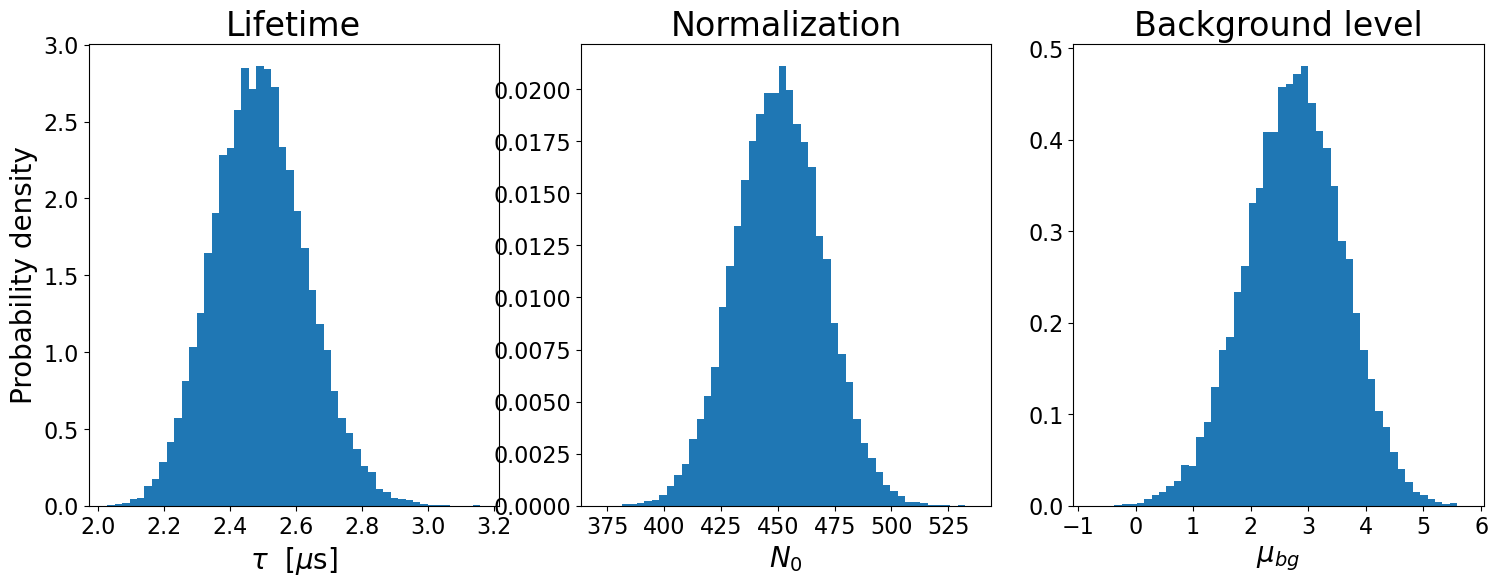

In [9]:
# Already set above
#
# Nmin = 100

# plt.figure(figsize=(10,8))
plt.subplots(1,3,figsize=(18, 6))

plt.subplot(131)

plt.hist(parhist[Nmin:,0],density=True,log=False,bins=50)

plt.xlabel(r'$\tau$  [$\mu$s]',size=20)
plt.ylabel('Probability density',size=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("Lifetime",size=24)

plt.subplot(132)

plt.hist(parhist[Nmin:,1],density=True,log=False,bins=50)

plt.xlabel(r'$N_{0}$',size=20)
#plt.ylabel('Probability',size=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("Normalization",size=24)

plt.subplot(133)

plt.hist(parhist[Nmin:,2],density=True,log=False,bins=50)

plt.xlabel(r'$\mu_{bg}$',size=20)
#plt.ylabel('Probability',size=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("Background level",size=24)


fname = '14_mcfit2_'+str(Nmc)+'_'+str(UseBG)+'.png'

plt.savefig(fname,format='png')

plt.show()